# Experiments to find combinatorial network baseline hypeparameters

In [1]:
def plot_folders(folders,saveas=None,ymin=0,dymax=0.05,rolling=3,labels=None,kfold=None):

    dfs = []
    if kfold is not None:
        maxep = []
        ymax = []
        for folder in folders:
            gb = pd.concat([ pd.read_csv('../logs/'+folder+'/fold_%d_%d/metrics.csv' % (kfold,ifold)) for ifold in range(kfold) ]).groupby('epoch')
            mean = gb.mean()
            std  = gb.std()
            dfs.append((mean,std))
            maxep.append(mean.index.max())
            ymax.append(mean.val_r2_score0.max())
            rolling = None
        max_dfepoch = min(maxep)
        ymax = max(ymax)+dymax    
    else:
        dfs = [ pd.read_csv('../logs/'+folder+'/metrics.csv') for folder in folders ]
        max_dfepoch = min( [df.epoch.max() for df in dfs] )
        ymax = max([df[["val_r2_score0"]].values.max() for df in dfs])+dymax

    minepoch = 100
    maxepoch = 10000

    if max_dfepoch < minepoch:
        minepoch = 0



    if labels is None:
        labels = folders
    plt.figure(figsize=(20,10))
    for df,name,label in zip(dfs,folders,labels):
        sub = plt.subplot(121)
        # print(df.val_r2_score0)
        if rolling is not None:
            mean = df.val_r2_score0.rolling(3).mean()
            std = df.val_r2_score0.rolling(3).std()
            plt.plot(df.epoch,mean,"o-",markersize=5.,label=label)
            plt.fill_between(df.epoch,mean+0.5*std,mean-0.5*std,alpha=0.5)
        elif kfold is not None:
            mean,std = df
            plt.plot(mean.index,mean.val_r2_score0,"o-",markersize=5.,label=label)
            plt.fill_between(mean.index,mean.val_r2_score0+0.5*std.val_r2_score0,mean.val_r2_score0-0.5*std.val_r2_score0,alpha=0.5)
        else:
            plt.plot(df.epoch,df.val_r2_score0,"o-",markersize=5.,label=label)
        sub = plt.subplot(122)
        if kfold is not None:
            std.r2_score0 *= np.sqrt(kfold)
            plt.plot(mean.index,mean.r2_score0,"o-",markersize=5.,label=label)
            plt.fill_between(mean.index,mean.r2_score0+0.5*std.r2_score0,mean.r2_score0-0.5*std.r2_score0,alpha=0.5)
        else:
            plt.plot(df.epoch,df.r2_score0,"o-",markersize=5.,label=label)

    labels = ["valid","train"]
    if rolling is not None:
        labels[0] += " (rolling mean %d epochs)" % rolling
    if kfold is not None:
        labels[0] += " (x-validation mean k=%d)" % kfold
    for iplt,lbl in zip([1,2],labels):
        sub = plt.subplot(120+iplt)
        plt.ylim(ymin,ymax)
        plt.ylabel("R2 "+lbl)
        plt.xlabel("epoch")
        plt.grid()
        plt.legend()
    if saveas is not None:
        plt.savefig(saveas)
    plt.show()

# Executive summary

See below for all experiments

/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


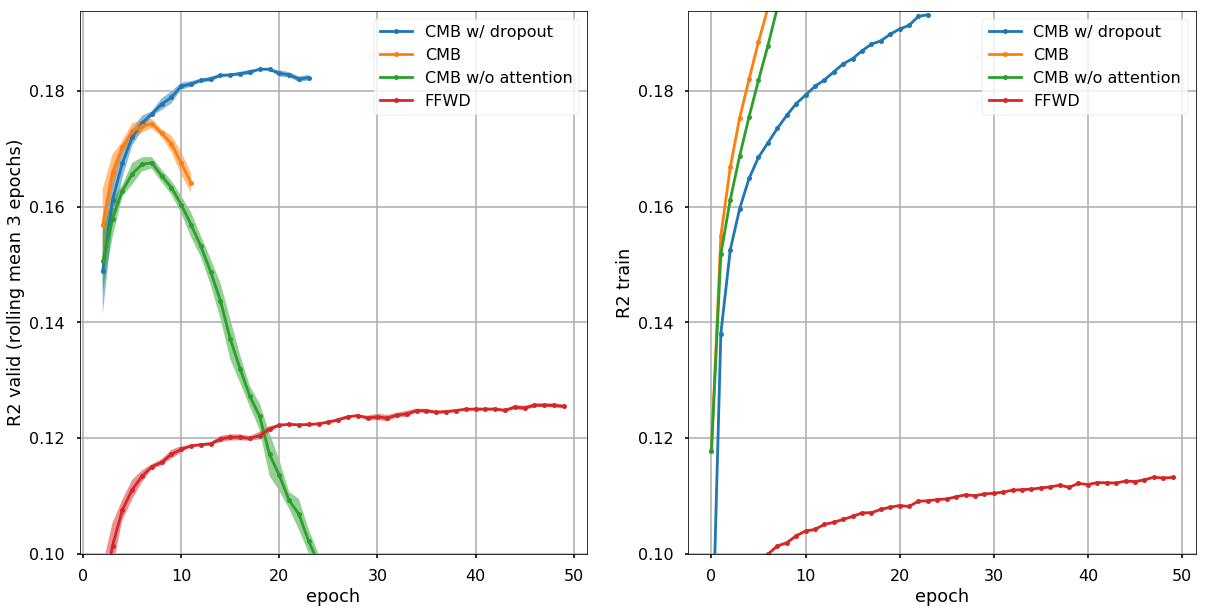

In [97]:
dofolders = ["mse_exp_cmb_delphes_had_doa1","mse_exp_cmb_delphes_had"]
# dofolders += []
dofolders += ["mse_exp_cmb_noatt_delphes_had","mse_exp_ffwd_delphes_had"]

plot_folders(dofolders,ymin=0.1,dymax=0.01,labels=["CMB w/ dropout","CMB","CMB w/o attention","FFWD"],saveas="delphes_opt.png")

## Test different kind of target definitions

* cmb: combinatorial network
* exp: exponnential transformation for target $y = exp(-y)$
* target is normalized by default $y = (y - y.mean()) / y.std()$
* nonorm: target not normalized
* huber: use huber loss instead of mse
* noatt: no attention field

/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


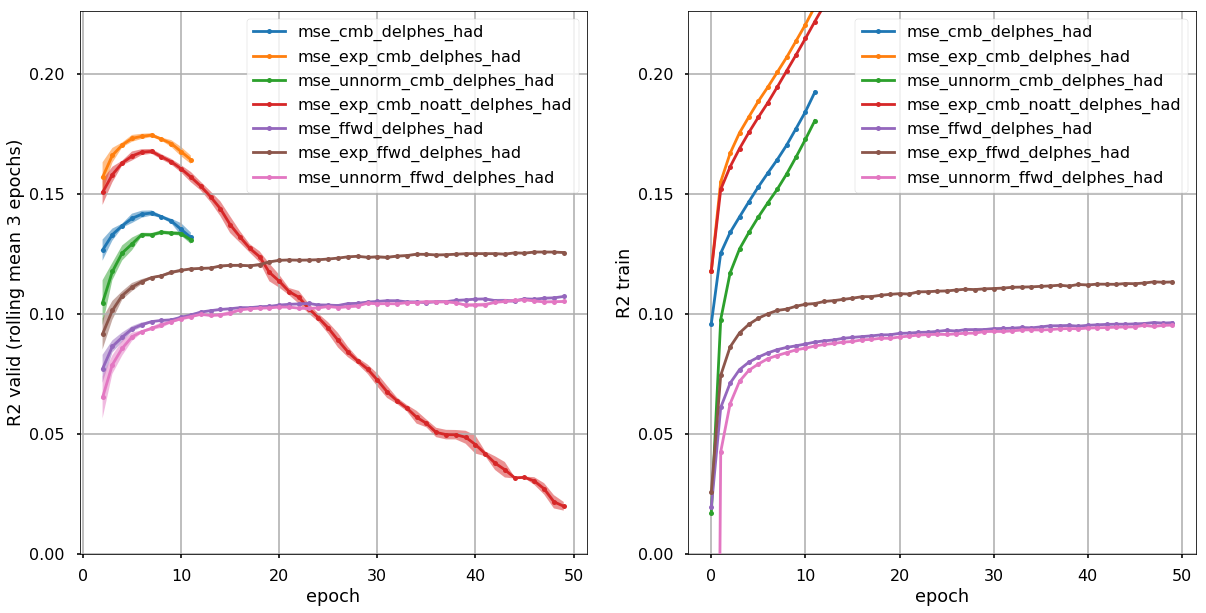

In [79]:
delphes = [#"huber_cmb_delphes_had",
            "mse_cmb_delphes_had","mse_exp_cmb_delphes_had","mse_unnorm_cmb_delphes_had",
    "mse_exp_cmb_noatt_delphes_had",
           # "huber_ffwd_delphes_had",
        "mse_ffwd_delphes_had","mse_exp_ffwd_delphes_had","mse_unnorm_ffwd_delphes_had"]

plot_folders(delphes,"delphes_had.png")

### Same as above but for CMS dataset

/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


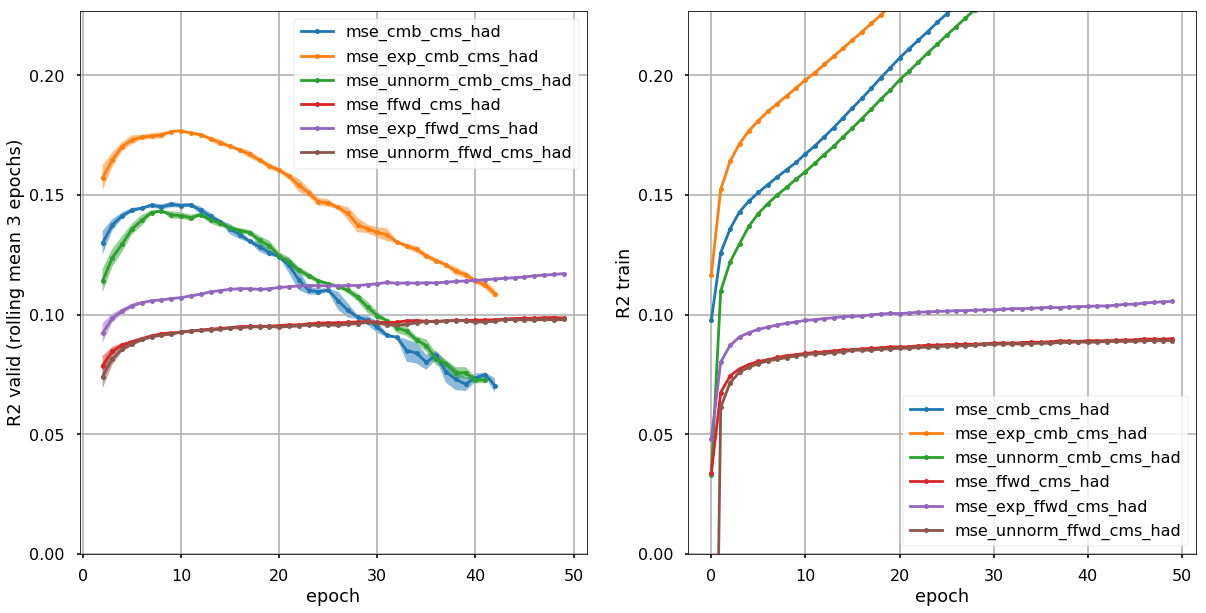

In [80]:
cms = [#"huber_cmb_cms_had",
    "mse_cmb_cms_had","mse_exp_cmb_cms_had","mse_unnorm_cmb_cms_had",
        #"huber_ffwd_cms_had",
    "mse_ffwd_cms_had","mse_exp_ffwd_cms_had","mse_unnorm_ffwd_cms_had"]

plot_folders(cms,"cms_had.png")

## Experiments with dropout

```
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_do1  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.5  --trijet-dropout 0.,0.2,0.5 --fc-dropout 0.5,0.5                                                                                                                            
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_do2  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2 --trijet-dropout 0.,0.2,0.2 --fc-dropout 0.5,0.5                                                                                                                            
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_do3  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --fc-dropout 0.2,0.2                                                                                                                            
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_do4  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --fc-dropout 0.5,0.5                                                                                                                                                                                    
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_do5  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --fc-dropout 0.2,0.2
```

/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


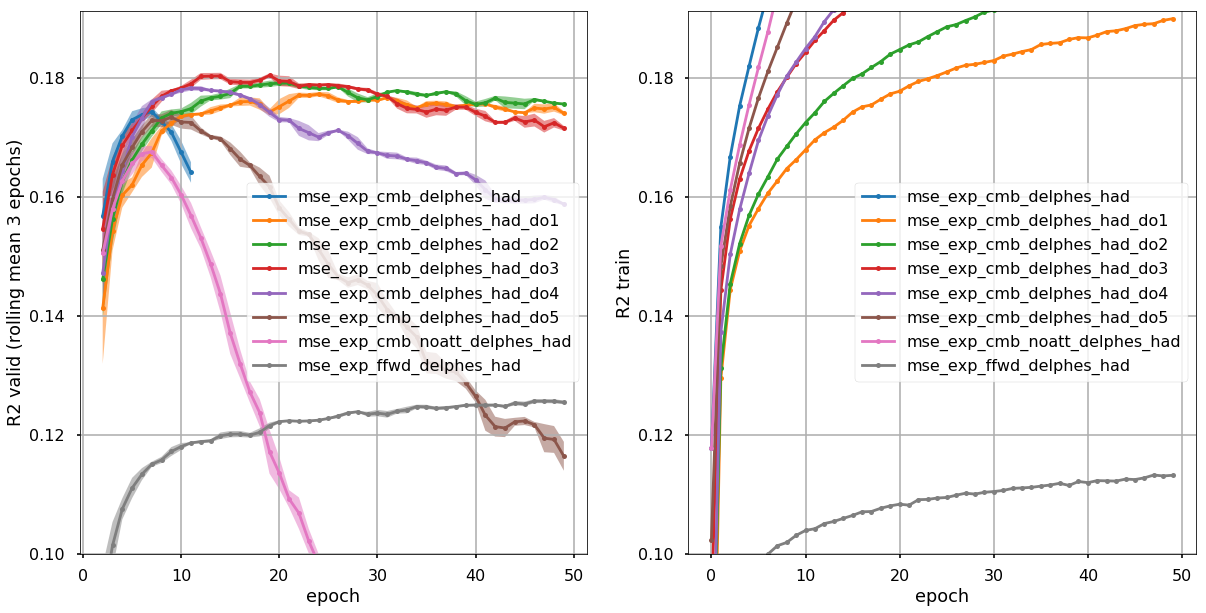

In [81]:
dofolders = ["mse_exp_cmb_delphes_had"]
dofolders += ["mse_exp_cmb_delphes_had_do%d" % ido for ido in range(1,6)]
dofolders += ["mse_exp_cmb_noatt_delphes_had","mse_exp_ffwd_delphes_had"]
plot_folders(dofolders,ymin=0.1,dymax=0.01)

Best option is do3
```
--dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --fc-dropout 0.2,0.2 
```

## Experiments with noise regularization

* inject noise in 2 and 3 jets convolutions
```
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no1  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
        --dijet-dropout 0.,0.,0.2  --trijet-dropout 0.,0.,0.2 --trijet-noise 0.,0.05,0.05  --dijet-noise 0.,0.05,0.05 --fc-dropout 0.2,0.2                                                                      
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no2  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
        --dijet-dropout 0.,0.,0.2  --trijet-dropout 0.,0.,0.2 --trijet-noise 0.,0.1,0.1  --dijet-noise 0.,0.1,0.1 --fc-dropout 0.2,0.2                                                                          
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no3  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
        --dijet-dropout 0.,0.,0.2  --trijet-dropout 0.,0.,0.2 --trijet-noise 0.,0.15,0.15  --dijet-noise 0.,0.15,0.15 --fc-dropout 0.2,0.2                                                                      
```
* inject noise in attention layers
```
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no4  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-noise 0.05,0.05 --fc-dropout 0.2,0.2                                                                                               
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no5  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-noise 0.1,0.1 --fc-dropout 0.2,0.2                                                                                                  
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_no6  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-noise 0.15,0.15 --fc-dropout 0.2,0.2 
```


/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


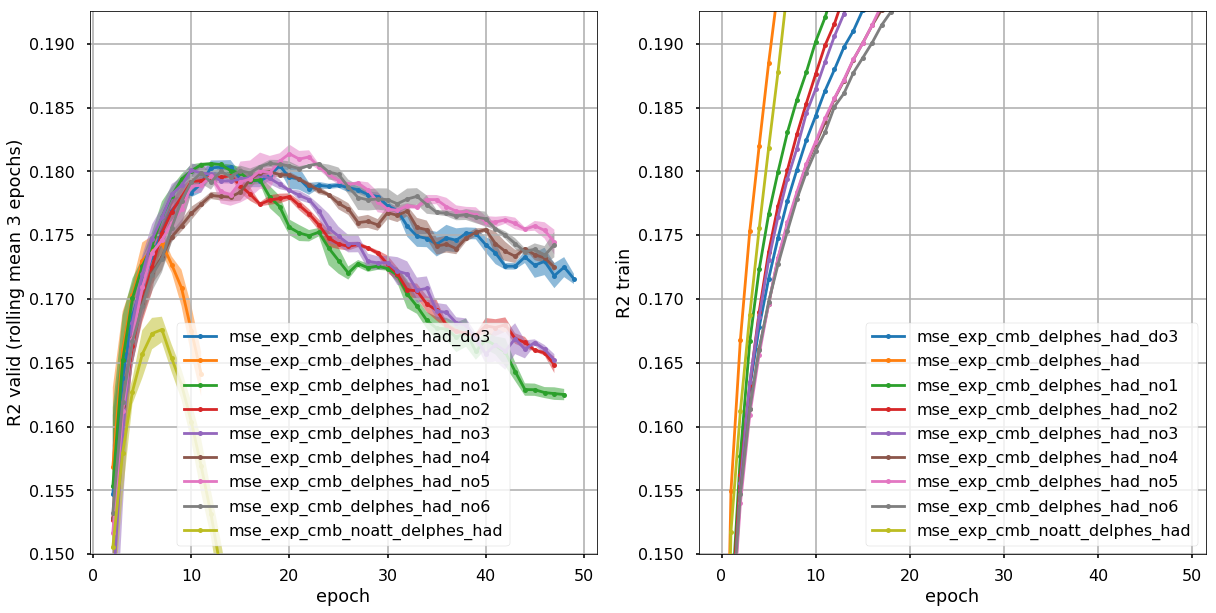

In [82]:
dofolders = ["mse_exp_cmb_delphes_had_do3","mse_exp_cmb_delphes_had"]
# dofolders += ["mse_exp_cmb_delphes_had_doj%d" % ido for ido in range(1,2)]
dofolders += ["mse_exp_cmb_delphes_had_no%d" % ido for ido in range(1,7)]
dofolders += ["mse_exp_cmb_noatt_delphes_had"]
# dofolders += ["mse_exp_ffwd_delphes_had"]
plot_folders(dofolders,ymin=0.15,dymax=0.01)

Best option is no5, even though no6 shows a smaller variance of validation error.
* no5 ` --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-noise 0.1,0.1 --fc-dropout 0.2,0.2`
* no6 `--dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-noise 0.15,0.15 --fc-dropout 0.2,0.2`

## Experiments with dropout in attention layers
```
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_doa1  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-dropout 0.2,0.2 --fc-dropout 0.2,0.2
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_doa2  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-dropout 0.3,0.3 --fc-dropout 0.2,0.2
sbatch train_model.sh python ./train_model.py --epochs 50 --architecture cmb  --out-dir mse_exp_cmb_delphes_had_doa3  --exp-target --loss mse --inp-dir SCRATCH/delphes_tth_had \
    --dijet-dropout 0.,0.2,0.2  --trijet-dropout 0.,0.2,0.2 --attention-dropout 0.5,0.5 --fc-dropout 0.2,0.2
```


/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


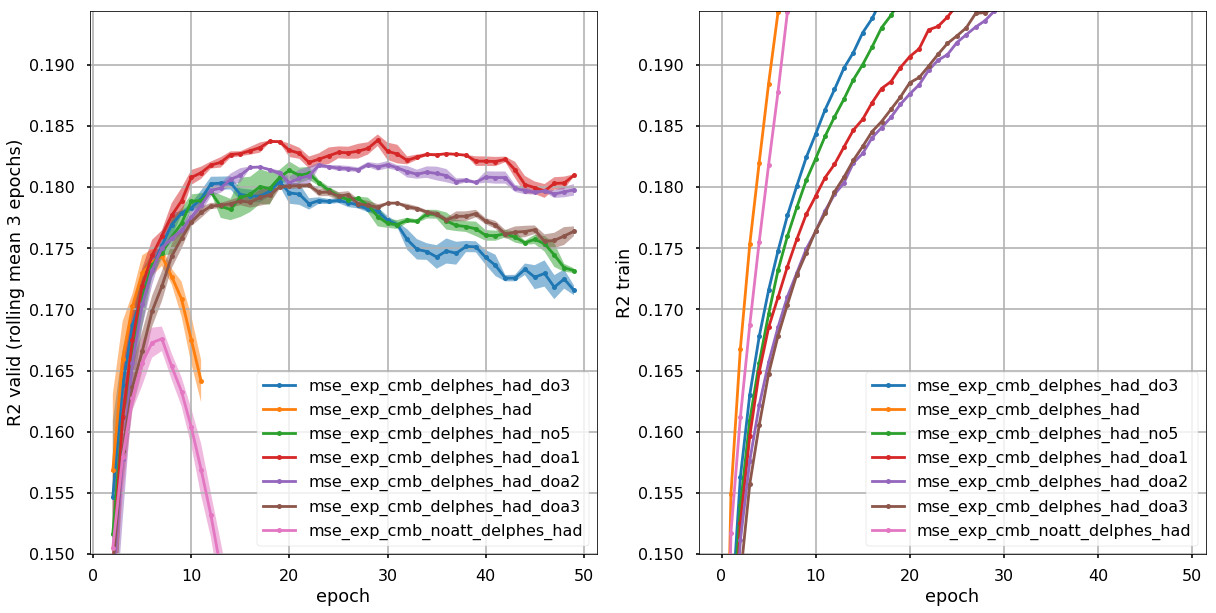

In [113]:
dofolders = ["mse_exp_cmb_delphes_had_do3","mse_exp_cmb_delphes_had","mse_exp_cmb_delphes_had_no5"]
dofolders += ["mse_exp_cmb_delphes_had_doa%d" % ido for ido in range(1,4)]
dofolders += ["mse_exp_cmb_noatt_delphes_had"] 
plot_folders(dofolders,ymin=0.15,dymax=0.01,rolling=3)

In [84]:
# dofolders = ["mse_exp_cmb_delphes_had_do3","mse_exp_cmb_delphes_had","mse_exp_cmb_delphes_had_no5","mse_exp_cmb_delphes_had_doa1"]
# dofolders += ["mse_exp_cmb_rnn_delphes_had", "mse_exp_cmb_rnn_delphes_had_do"]
# dofolders += ["mse_exp_cmb_noatt_delphes_had","mse_exp_ffwd_delphes_had"]

# plot_folders(dofolders,ymin=0.0,dymax=0.01,rolling=None)

/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


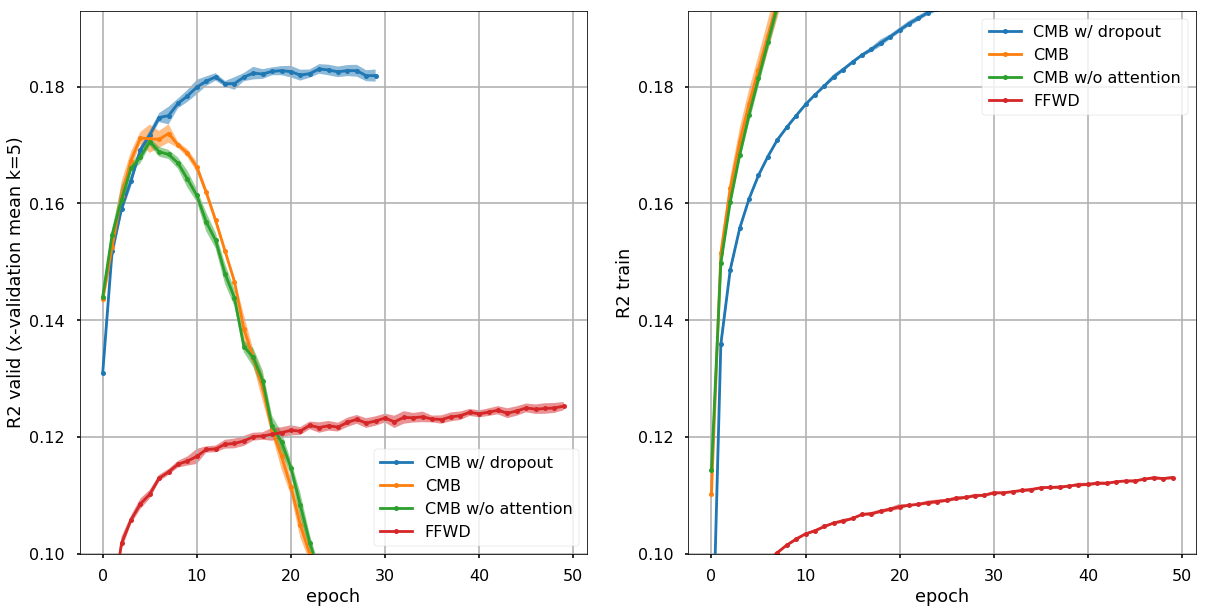

In [142]:
dofolders = ["xval/mse_exp_cmb_delphes_had_doa1","xval/mse_exp_cmb_delphes_had"]
# dofolders += []
## dofolders += ["xval/mse_exp_cmb_noatt_delphes_had"]
dofolders += ["xval/mse_exp_cmb_noatt_delphes_had","xval/mse_exp_ffwd_delphes_had"]

plot_folders(dofolders,ymin=0.1,dymax=0.01,kfold=5,labels=["CMB w/ dropout","CMB","CMB w/o attention","FFWD"],saveas="delphes_opt_kfold.png")


/users/musella/my-env3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


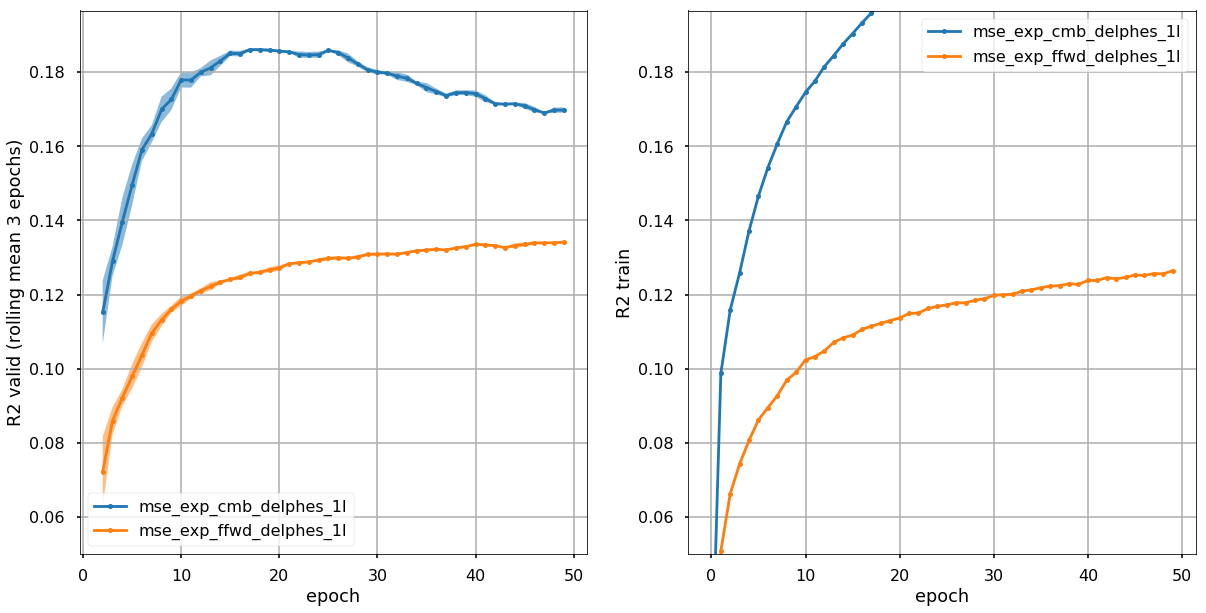

In [16]:
dofolders = ["mse_exp_cmb_delphes_1l","mse_exp_ffwd_delphes_1l"]
plot_folders(dofolders,ymin=0.05,dymax=0.01)
